# 一、导入数据

In [56]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LassoCV
from scipy.stats import ttest_ind, levene
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

data_LA = pd.read_csv("input/LA_total.csv",index_col=0)
data_XA = pd.read_csv("input/XA_total.csv",index_col=0)


data_LA_ = pd.DataFrame()
columns_LA = data_LA.columns
for col in columns_LA:
    try:
        df = data_LA[col].astype(np.float64)
        data_LA_ = pd.concat([data_LA_,df],axis=1)
    except:
        pass
    continue
    
data_XA_ = pd.DataFrame()
columns_XA = data_XA.columns
for col in columns_XA:
    try:
        df = data_XA[col].astype(np.float64)
        data_XA_ = pd.concat([data_XA_,df],axis=1)
    except:
        pass
    continue


# 方差齐性
index_ = []
for col in data_LA_.columns:
    if levene(data_LA_[col],data_XA_[col])[1] > 0.05:
        if ttest_ind(data_LA_[col],data_XA_[col])[1] < 0.05:
            index_.append(col)
    else:
        if ttest_ind(data_LA_[col],data_XA_[col],equal_var=False)[1] < 0.05:
            index_.append(col)


data_L_T = data_LA_[index_]
data_X_T = data_XA_[index_]


data = pd.concat([data_L_T,data_X_T])
data = shuffle(data)

target = data.iloc[:, 0]
features = data.iloc[:,1:]
features_bk = features.copy()

transfer = StandardScaler()
features_SS = transfer.fit_transform(features_bk)
# 数据标准化很有必要

alphas_ = np.logspace(-2,0,300)


lassocv = LassoCV(alphas = alphas_,cv = 10,max_iter = 100000).fit(features_SS,target)
lassocv.alpha_
features = data[features.columns[lassocv.coef_!=0]]
print(len(features.columns))
# print(lassocv.coef_[lassocv.coef_!=0])

transfer = StandardScaler()
features_SS = transfer.fit_transform(features)

18


In [57]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_target, test_target = train_test_split(
    features_SS, target, 
    test_size = 0.3)

# 四、交叉验证

In [58]:
from sklearn.model_selection import KFold,ShuffleSplit,cross_val_score,RepeatedKFold

In [59]:
kf = KFold(n_splits=10)

In [60]:
ss = ShuffleSplit(n_splits=10, test_size=0.2, random_state=99)

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [62]:
log_clf = LogisticRegression(max_iter = 1000000)
svc_clf = SVC()
tree_clf = DecisionTreeClassifier()

In [63]:
log_score = cross_val_score(log_clf, train_features, train_target, cv=ss)
log_score

array([0.65, 0.6 , 0.7 , 0.6 , 0.7 , 0.7 , 0.7 , 0.7 , 0.6 , 0.6 ])

In [64]:
svc_score = cross_val_score(svc_clf, train_features, train_target, cv=ss)
svc_score

array([0.6 , 0.55, 0.75, 0.55, 0.7 , 0.7 , 0.75, 0.55, 0.5 , 0.75])

In [65]:
tree_score = cross_val_score(tree_clf, train_features, train_target, cv=ss)
tree_score

array([0.5 , 0.5 , 0.5 , 0.45, 0.75, 0.7 , 0.65, 0.7 , 0.65, 0.75])

In [66]:
print(log_score.mean())
print(svc_score.mean())
print(tree_score.mean())

0.6549999999999999
0.64
0.615


In [67]:

rkf=RepeatedKFold(n_splits=10,n_repeats=3)
for train_index, test_index in rkf.split(train_features):
    X_train =pd.DataFrame(train_features).iloc[train_index]
    X_test =pd.DataFrame(train_features).iloc[test_index]
    y_train =pd.DataFrame(train_target).iloc[train_index]
    y_test =pd.DataFrame(train_target).iloc[test_index]
    model_svm = SVC(kernel='rbf',probability = True).fit(X_train,y_train)
    score_svm=model_svm.score(X_test,y_test)
    print(score_svm)

0.5
0.8
0.6
0.7
0.7
0.7
0.4444444444444444
0.5555555555555556
0.7777777777777778
0.7777777777777778
0.9
0.8
0.7
0.6
0.6
0.6
0.7777777777777778
0.7777777777777778
0.4444444444444444
0.6666666666666666
0.8
0.9
0.8
0.7
0.7
0.4
0.3333333333333333
0.7777777777777778
1.0
0.3333333333333333


# 五、网格搜索

In [13]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [14]:
param_grid = {'C': [0.1, 1, 10],'gamma': [0.1, 0.5, 1, 5]}

In [15]:
grid_research = GridSearchCV(svc_clf, param_grid, cv=ss)

In [16]:
grid_research.fit(train_features, train_target)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=99, test_size=0.2, train_size=None),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.1, 0.5, 1, 5]})

In [17]:
grid_research.best_params_

{'C': 1, 'gamma': 0.1}

In [18]:
grid_research.best_score_

0.6363636363636365

In [19]:
grid_research.best_estimator_

SVC(C=1, gamma=0.1)

In [20]:
param_distributions={'C': np.logspace(-3,3,200),'gamma': np.logspace(-3,3,200), 'kernel': ['linear', 'rbf']}

In [21]:
random_search =RandomizedSearchCV(svc_clf, param_distributions, cv=ss, n_iter=100)

In [22]:
random_search.fit(train_features, train_target)

RandomizedSearchCV(cv=ShuffleSplit(n_splits=10, random_state=99, test_size=0.2, train_size=None),
                   estimator=SVC(), n_iter=100,
                   param_distributions={'C': array([1.00000000e-03, 1.07189132e-03, 1.14895100e-03, 1.23155060e-03,
       1.32008840e-03, 1.41499130e-03, 1.51671689e-03, 1.62575567e-03,
       1.74263339e-03, 1.86791360e-03, 2.00220037e-03, 2.14614120e-03,
       2.30043012e-03, 2....
       2.02550194e+02, 2.17111795e+02, 2.32720248e+02, 2.49450814e+02,
       2.67384162e+02, 2.86606762e+02, 3.07211300e+02, 3.29297126e+02,
       3.52970730e+02, 3.78346262e+02, 4.05546074e+02, 4.34701316e+02,
       4.65952567e+02, 4.99450512e+02, 5.35356668e+02, 5.73844165e+02,
       6.15098579e+02, 6.59318827e+02, 7.06718127e+02, 7.57525026e+02,
       8.11984499e+02, 8.70359136e+02, 9.32930403e+02, 1.00000000e+03]),
                                        'kernel': ['linear', 'rbf']})

In [23]:
random_search.best_params_

{'kernel': 'linear', 'gamma': 0.5542664520663102, 'C': 0.0644236350872137}

In [24]:
random_search.best_score_

0.7045454545454546

In [25]:
random_search.best_estimator_

SVC(C=0.0644236350872137, gamma=0.5542664520663102, kernel='linear')

In [26]:
random_search.best_estimator_.score(test_features, test_target)

0.7142857142857143

# 六、知识拓展

In [27]:
Cs = np.logspace(-3,2,200)

In [28]:
acc_=[]
coef_ = []
for C_ in Cs:
    log_l1 = LogisticRegression(penalty='l1',C = C_, solver='liblinear')
    log_l1.fit(train_features, train_target)
    coef_.append(log_l1.coef_)
    score = cross_val_score(log_l1, train_features, train_target, cv=ss)
    acc_.append(score.mean())

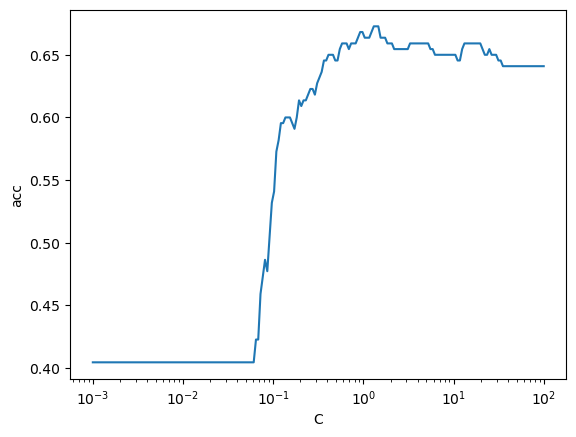

In [29]:
import matplotlib.pyplot as plt
plt.plot(Cs, acc_)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('acc')
plt.show()

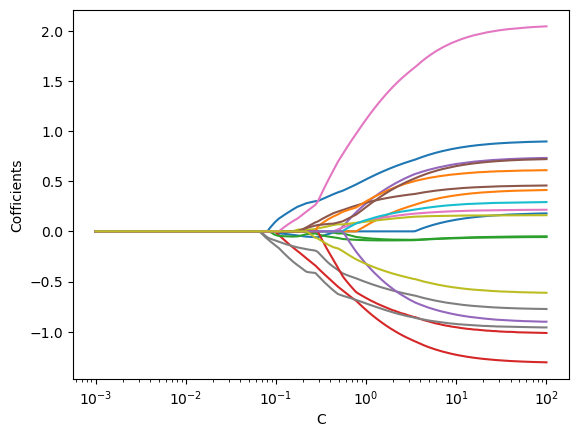

In [31]:
coef_ = np.array(coef_).reshape(200,19)
plt.plot(Cs, coef_)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Cofficients')
plt.show()

In [32]:
np.argmax(acc_)

124

In [34]:
Cs[124]

1.3049019780144029

In [ ]:
print('test')